In [14]:
from skbio.diversity.alpha import simpson
import feature_extraction
import baselines
from datasets import Dataset
import numpy as np
import adaptive_sampling
import math
import matplotlib.pyplot as plt
from scipy.special import kl_div

In [2]:
def convert_to_hf_dataset(dataset, sampled_indices):
    sampled_data = [dataset[idx] for idx in sampled_indices]
    hf_dataset = Dataset.from_dict(
        {key: [d[key] for d in sampled_data] for key in sampled_data[0]}
    )
    return hf_dataset

In [4]:
dataset, embeddings_dict = feature_extraction.create_embeddings_for_sampling()

# sample_counts = [i for i in range(50, 0, -1)]


kmeans_samples, kmeans_indices = baselines.kmeans_sampling(
    embeddings_dict, n_clusters=10, n_samples=10
)
random_samples, random_indices = baselines.random_sampling(
    embeddings_dict, n_samples=10
)

random_sample_dataset = convert_to_hf_dataset(dataset, random_indices)
kmeans_sample_dataset = convert_to_hf_dataset(dataset, kmeans_indices)

baseline_samples = {
    "random": random_sample_dataset,
    "kmeans": kmeans_sample_dataset,
}



Resolving data files:   0%|          | 0/3618 [00:00<?, ?it/s]

In [18]:
kmeans_counts = np.bincount(kmeans_sample_dataset["label"])
random_counts = np.bincount(random_sample_dataset["label"])

kmeans_si = simpson(kmeans_counts)
random_si = simpson(random_counts)

print(kmeans_si, random_si)

0.31999999999999984 0.0


In [21]:
original_si = simpson(np.bincount(dataset["label"]))
original_si

0.14838772173161585

In [19]:
original_counts = np.bincount(dataset['label'])
original_prob = original_counts / original_counts.sum()

kmeans_prob = kmeans_counts/kmeans_counts.sum()
random_prob = random_counts/random_counts.sum()

max_length = max(len(original_prob), len(kmeans_prob))

original_prob = np.pad(original_prob, (0, max_length - len(original_prob)), 'constant')
kmeans_prob = np.pad(kmeans_prob, (0, max_length - len(kmeans_prob)), 'constant')
random_prob = np.pad(random_prob, (0, max_length - len(random_prob)), 'constant')

 

In [20]:
kmeans_kl = np.sum(kl_div(original_prob, kmeans_prob))
random_kl = np.sum(kl_div(original_prob, random_prob))

print(kmeans_kl, random_kl)

0.054533885924862524 inf


In [7]:
density_scores = adaptive_sampling.calculate_density(embeddings_dict)

adaptive_samples, adaptive_indices = adaptive_sampling.adaptive_sampler(
    embeddings_dict, density_scores, max_samples=10
)

adaptive_sample_dataset = convert_to_hf_dataset(dataset, adaptive_indices)

adaptive_si = simpson(np.bincount(adaptive_sample_dataset["label"]))

adaptive_si

0.0

In [12]:
def display_images(dataset, img_indices):
    print(f"Displaying {len(img_indices)} images!")
    num_images = len(img_indices)
    num_cols = 5
    num_rows = math.ceil(num_images / num_cols)
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 3, num_rows * 3))
    axes = axes.flatten()
    for idx, image_idx in enumerate(img_indices):
        image = dataset[image_idx]["image"]
        axes[idx].imshow(image)
        axes[idx].set_title(f"Image Index: {image_idx}")
        axes[idx].axis("off")
    for ax in axes[num_images:]:
        ax.axis("off")
    plt.tight_layout()
    plt.show()

Displaying 10 images!


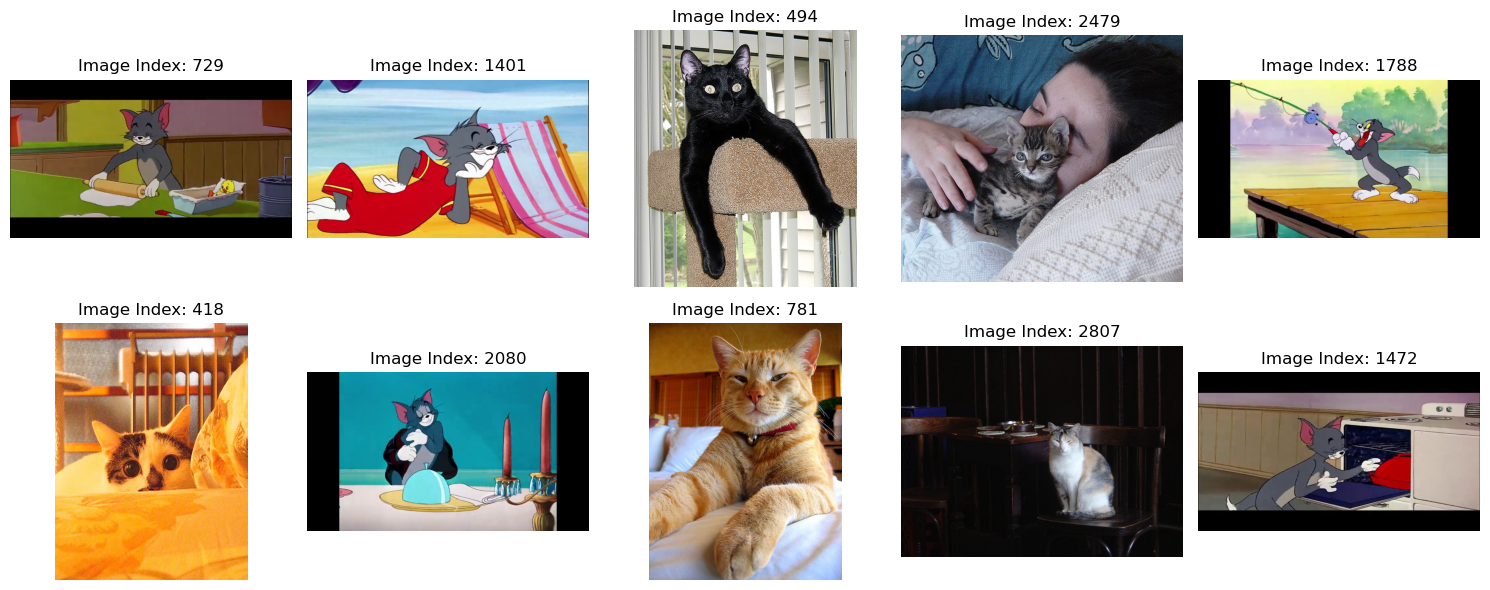

Displaying 10 images!


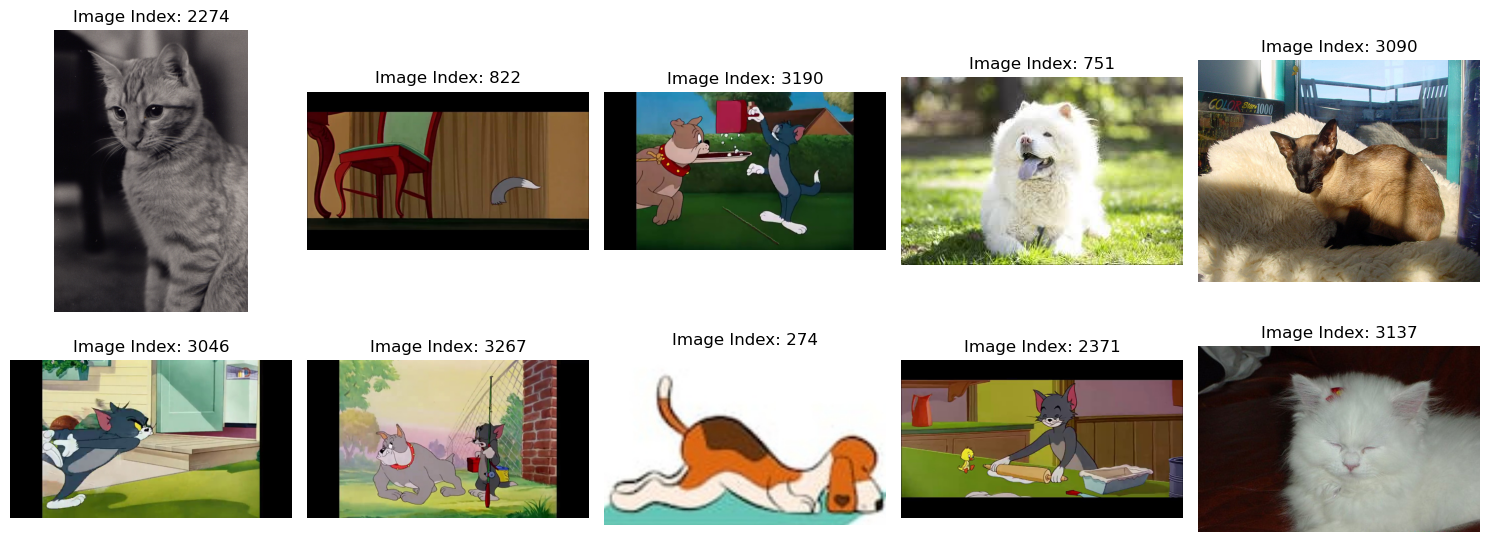

Displaying 10 images!


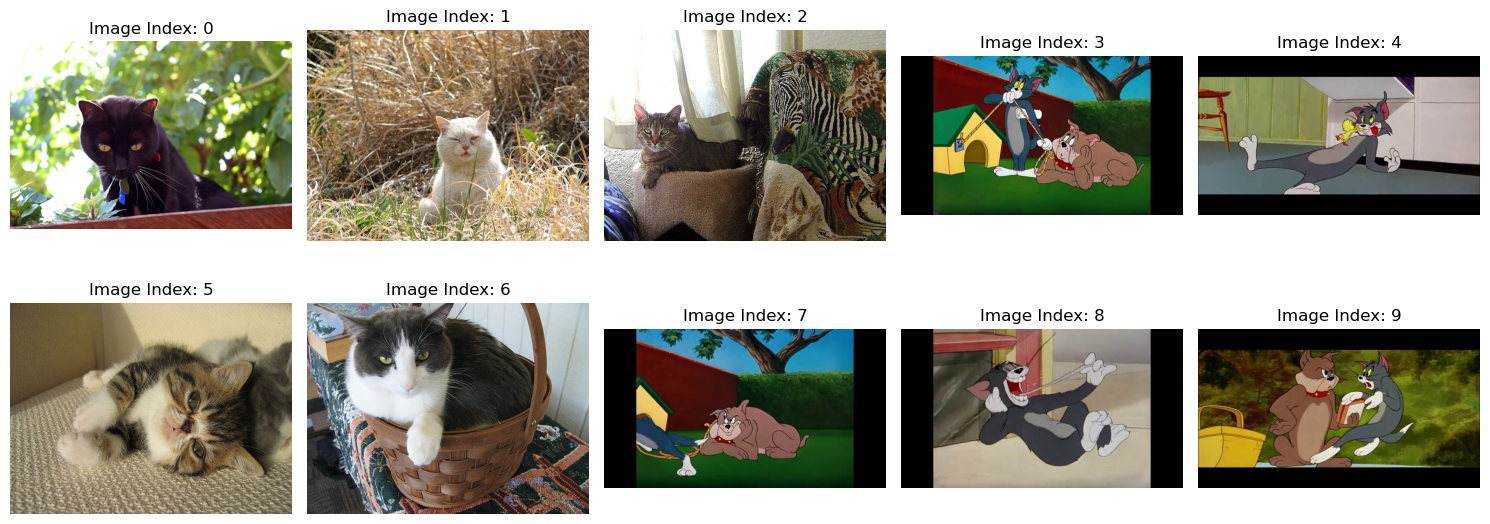

In [13]:
display_images(dataset, random_indices)
display_images(dataset, kmeans_indices)
display_images(dataset, adaptive_indices)